In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
!wget https://gist.github.com/mbejda/7f86ca901fe41bc14a63/archive/38adb475c14a3f44df9999c1541f3a72f472b30d.zip
!unzip 38adb475c14a3f44df9999c1541f3a72f472b30d.zip
import pandas as pd
file_path = '/content/7f86ca901fe41bc14a63-38adb475c14a3f44df9999c1541f3a72f472b30d/Indian-Male-Names.csv'
df = pd.read_csv(file_path)
names = df['name']
output_file = 'names.txt'
names.to_csv(output_file, index=False, header=False)

--2024-06-10 21:03:08--  https://gist.github.com/mbejda/7f86ca901fe41bc14a63/archive/38adb475c14a3f44df9999c1541f3a72f472b30d.zip
Resolving gist.github.com (gist.github.com)... 140.82.112.3
Connecting to gist.github.com (gist.github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gist/7f86ca901fe41bc14a63/zip/38adb475c14a3f44df9999c1541f3a72f472b30d [following]
--2024-06-10 21:03:08--  https://codeload.github.com/gist/7f86ca901fe41bc14a63/zip/38adb475c14a3f44df9999c1541f3a72f472b30d
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘38adb475c14a3f44df9999c1541f3a72f472b30d.zip’

38adb475c14a3f44df9     [ <=>                ]  68.09K  --.-KB/s    in 0.08s   

2024-06-10 21:03:09 (832 KB/s) - ‘38adb475c14a3f44df

In [3]:
# Formatting the data
alphabets = set("abcdefghijklmnopqrstuvwxyz")
words=open('names.txt','r').read().splitlines()
words = [name for name in words if all(char in alphabets for char in name.lower()) and ' ' not in name]
words[0]="samyak"
words = list(set(words))


In [4]:
len(words) #6429 without filtering

2198

In [5]:
# Building the vocabulary of characters and maping to/from integers
chars=sorted(list(set(''.join(words))))
stoi= {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
# Building the dataset
block_size=3
def build_dataset(words):

  X,Y=[],[]

  for w in words:
    # print(w)
    context=[0]*block_size
    for ch in w+ '.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context),'--->', itos[ix])
      context=context[1:]+[ix]
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

In [7]:
# Dataset
Xtr.shape, Ytr.shape,Xdev.shape, Ydev.shape,Xte.shape, Yte.shape

(torch.Size([13442, 3]),
 torch.Size([13442]),
 torch.Size([1691, 3]),
 torch.Size([1691]),
 torch.Size([1672, 3]),
 torch.Size([1672]))

In [8]:
def cmp(s,dt,t):
  ex=torch.all(dt == t.grad).item()
  app=torch.allclose(dt,t.grad)
  maxdiff=(dt-t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate:{str(app):5s} | maxdiff: {maxdiff}')

In [9]:
# Hyperparameter for the model
embedding_input=2
emb_input=block_size*embedding_input
neurons=6
outputs=27
# ----

g=torch.Generator().manual_seed(19)
C=torch.randn((outputs,embedding_input),generator=g)
# Layer 1
W1=torch.randn((emb_input,neurons)     ,generator=g) * (5/3)/(emb_input**0.5)
b1=torch.randn(neurons                 ,generator=g) *0.1
#Layer 2
W2=torch.randn((neurons,outputs)       ,generator=g) *0.1
b2=torch.randn(outputs                 ,generator=g) *0.1
# BatchNorm params
bngain=torch.randn((1,neurons))*0.1+1.0
bnbias=torch.randn((1,neurons))*0.1

parameters=[C,W1,b1,W2,b2,bngain,bnbias]
total_elements=0
for p in parameters:
    total_elements += p.nelement()
print(total_elements)
for p in parameters:
  p.requires_grad=True

297


In [10]:
batch_size=16
n=batch_size
# minibatch construct
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
Xb,Yb=Xtr[ix],Ytr[ix]


In [11]:

# Forward pass
emb=C[Xb]
embcat=emb.view(emb.shape[0],-1)
# Linear layer 1
hprebn=embcat @ W1 +b1
# BatchNorm layer
bnmeani=1/n*hprebn.sum(0,keepdim=True)
bndiff=hprebn-bnmeani
bndiff2=bndiff**2
bnvar=1/(n-1)*(bndiff2).sum(0,keepdim=True) #Bessel's correction i.e dividing by (n-1) not n
bnvar_inv=(bnvar+1e-5)**-0.5
bnraw=bndiff*bnvar_inv
hpreact= bngain*bnraw+bnbias
# Non Linearity
h=torch.tanh(hpreact) # hidden Layer

# Linear Layer 2
logits=h @W2 +b2 # output layer

# Before

# logit_maxes=logits.max(1,keepdim=True).values
# norm_logits=logits-logit_maxes
# counts=norm_logits.exp()
# counts_sum=counts.sum(1,keepdims=True)
# counts_sum_inv=counts_sum**-1
# probs=counts*counts_sum_inv
# logprobs=probs.log()
# loss=-logprobs[range(n),Yb].mean()
# # Pytorch backward pass
# for p in parameters:
#   p.grad=None
# for t in [logprobs,probs,counts_sum_inv,counts_sum,counts,norm_logits,
#           logit_maxes,logits,h,hpreact,bnraw,bnvar_inv,bnvar,
#           bndiff2,bndiff,bnmeani,hprebn,embcat,emb]:

# After

loss=F.cross_entropy(logits,Yb)
# Pytorch backward pass
for p in parameters:
  p.grad=None
for t in [loss,logits,h,hpreact,bnraw,bnvar_inv,bnvar,
          bndiff2,bndiff,bnmeani,hprebn,embcat,emb]:
  t.retain_grad()
loss.backward()
print(loss.item())


3.2418954372406006


In [12]:
emb.shape, C.shape,Xb.shape,Xb[:5]

(torch.Size([16, 3, 2]),
 torch.Size([27, 2]),
 torch.Size([16, 3]),
 tensor([[ 1, 12,  5],
         [ 5, 19,  8],
         [18,  5,  8],
         [ 0,  0, 13],
         [21, 14, 20]]))

In [13]:
C[1],emb[1,2]

(tensor([ 0.0273, -0.4079], grad_fn=<SelectBackward0>),
 tensor([-0.6840, -0.0029], grad_fn=<SelectBackward0>))

In [17]:
# Before

# dlogprobs = torch.zeros_like(logprobs)
# dlogprobs[range(n),Yb]=-1.0/n
# dprobs=(1.0/probs) * dlogprobs
# dcounts_sum_inv=(counts * dprobs).sum(1,keepdim=True)
# dcounts= counts_sum_inv*dprobs
# dcounts_sum=(-counts_sum**-2) * dcounts_sum_inv
# dcounts+= torch.ones_like(counts)*dcounts_sum
# dnorm_logits=counts*dcounts
# dlogits=dnorm_logits.clone()
# dlogit_maxes=  -1.0*dnorm_logits.sum(1,keepdim=True)
# dlogits+= F.one_hot(logits.max(1).indices,num_classes=logits.shape[1])*dlogit_maxes

# After

dlogits = F.softmax(logits,1)
dlogits[range(n),Yb]-=1
dlogits /= n

dh= dlogits @ W2.T
dW2=h.T @ dlogits
db2=dlogits.sum(0,keepdim=True)
dhpreact=(1 - h**2) * dh
dbngain= (bnraw * dhpreact).sum(0,keepdim=True)
dbnraw=dhpreact * bngain
dbnbias=dhpreact.sum(0,keepdim=True)
# dbndiff= bnvar_inv*dbnraw
# dbnvar_inv= (bndiff * dbnraw).sum(0,keepdim=True)
# dbnvar=(-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2= ((1.0/(n-1))*torch.ones_like(bndiff2))*dbnvar
# dbndiff+= 2*bndiff*dbndiff2
# dhprebn=1.0*dbndiff.clone()
# dbnmeani=-dbndiff.sum(0,keepdim=True)
# dhprebn+=(1/n)*torch.ones_like(hprebn)*dbnmeani
dhprebn=bngain*bnvar_inv/n*(n*dhpreact-dhpreact.sum(0)-(n/(n-1))*bnraw*(dhpreact*bnraw).sum(0))
dembcat= dhprebn @ W1.T
dW1= embcat.T @ dhprebn
db1 = 1.0*dhprebn.sum(0,keepdim=True)
demb=dembcat.view(emb.shape)
dC=torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix=Xb[k,j]
    dC[ix]+=demb[k,j]

# cmp('logprobs',dlogprobs,logprobs)
# cmp('probs',dprobs,probs)
# cmp('counts_sum_inv',dcounts_sum_inv,counts_sum_inv)
# cmp('counts_sum',dcounts_sum,counts_sum)
# cmp('counts',dcounts,counts)
# cmp('norm_logits',dnorm_logits,norm_logits)
# cmp('logit_maxes',dlogit_maxes,logit_maxes)
cmp('logits',dlogits,logits)
cmp('h',dh,h)
cmp('W2',dW2,W2)
cmp('b2',db2,b2)
cmp('hpreact',dhpreact,hpreact)
# cmp('bngain',dbngain,bngain)
# cmp('bnraw',dbnraw,bnraw)
# cmp('bnbias',dbnbias,bnbias)
# cmp('bnvar_inv',dbnvar_inv,bnvar_inv)
# cmp('bnvar',dbnvar,bnvar)
# cmp('bndiff2' ,dbndiff2,bndiff2)
# cmp('bndiff',dbndiff,bndiff)
# cmp('bnmeani',dbnmeani,bnmeani)
cmp('hprebn',dhprebn,hprebn)
cmp('embcat',dembcat,embcat)
cmp('W1',dW1,W1)
cmp('b1',db1,b1)
cmp('emb',demb,emb)
cmp('C',dC,C)

logits          | exact: False | approximate:True  | maxdiff: 3.725290298461914e-09
h               | exact: False | approximate:True  | maxdiff: 9.313225746154785e-10
W2              | exact: False | approximate:True  | maxdiff: 7.450580596923828e-09
b2              | exact: False | approximate:True  | maxdiff: 1.4901161193847656e-08
hpreact         | exact: False | approximate:True  | maxdiff: 9.313225746154785e-10
hprebn          | exact: False | approximate:True  | maxdiff: 1.862645149230957e-09
embcat          | exact: False | approximate:True  | maxdiff: 1.862645149230957e-09
W1              | exact: False | approximate:True  | maxdiff: 5.587935447692871e-09
b1              | exact: False | approximate:True  | maxdiff: 5.122274160385132e-09
emb             | exact: False | approximate:True  | maxdiff: 1.862645149230957e-09
C               | exact: False | approximate:True  | maxdiff: 3.259629011154175e-09


In [39]:
# Hyperparameter for the model
embedding_input=2
emb_input=block_size*embedding_input
neurons=6
outputs=27
# ----

g=torch.Generator().manual_seed(19)
C=torch.randn((outputs,embedding_input),generator=g)
# Layer 1
W1=torch.randn((emb_input,neurons)     ,generator=g) * (5/3)/(emb_input**0.5)
b1=torch.randn(neurons                 ,generator=g) *0.1
#Layer 2
W2=torch.randn((neurons,outputs)       ,generator=g) *0.1
b2=torch.randn(outputs                 ,generator=g) *0.1
# BatchNorm params
bngain=torch.randn((1,neurons))*0.1+1.0
bnbias=torch.randn((1,neurons))*0.1

parameters=[C,W1,b1,W2,b2,bngain,bnbias]
total_elements=0
for p in parameters:
    total_elements += p.nelement()
print(total_elements)
for p in parameters:
  p.requires_grad=True

# Hyperparameters
lri=[]
stepi=[]
lossi=[]
batch_size=16
max_steps=30000
lrs_e=[0.1,0.01]
ud=[]
batch_size=16
n=batch_size

with torch.no_grad():
  for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]
    # Forward pass
    emb=C[Xb]
    embcat=emb.view(emb.shape[0],-1)
    # Linear layer 1
    hprebn=embcat @ W1 +b1
    # BatchNorm layer
    bnmeani=1/n*hprebn.sum(0,keepdim=True)
    bndiff=hprebn-bnmeani
    bndiff2=bndiff**2
    bnvar=1/(n-1)*(bndiff2).sum(0,keepdim=True) #Bessel's correction i.e dividing by (n-1) not n
    bnvar_inv=(bnvar+1e-5)**-0.5
    bnraw=bndiff*bnvar_inv
    hpreact= bngain*bnraw+bnbias
    # Non Linearity
    h=torch.tanh(hpreact) # hidden Layer

    # Linear Layer 2
    logits=h @W2 +b2 # output layer


    loss=F.cross_entropy(logits,Yb)
    # Pytorch backward pass
    for p in parameters:
      p.grad=None

    # manual backward pass

    dlogits = F.softmax(logits,1)
    dlogits[range(n),Yb]-=1
    dlogits /= n
    # 2nd layer bp
    dh= dlogits @ W2.T
    dW2=h.T @ dlogits
    db2=dlogits.sum(0)
    # tanh
    dhpreact=(1.0 - h**2) * dh
    # batchnorm layer  bp
    dbngain= (bnraw * dhpreact).sum(0,keepdim=True)
    dbnbias=dhpreact.sum(0,keepdim=True)
    dhprebn=bngain*bnvar_inv/n*(n*dhpreact-dhpreact.sum(0)-(n/(n-1))*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat= dhprebn @ W1.T
    dW1= embcat.T @ dhprebn
    db1 = 1.0*dhprebn.sum(0)
    # embedding
    demb=dembcat.view(emb.shape)
    dC=torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix=Xb[k,j]
        dC[ix]+=demb[k,j]
    grads=[dC,dW1,db1,dW2,db2,dbngain,dbnbias]

    # Update

    lr=0.1 if i<10000 else 0.01
    for p,grad in zip(parameters,grads):
      p.data+= -lr*grad

    # Track stats

    if i % 10000==0:
      print(f'{1:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
  print(loss.item())


297
      1/  30000:3.3160
      1/  30000:2.4619
      1/  30000:2.3871
2.929645299911499


In [40]:
@torch.no_grad()
def split_loss(split):
  x,y={
      'train':{Xtr,Ytr},
      'val':{Xdev,Ydev},
      'test':{Xte,Yte},
  }[split]
  emb=C[x]
  embcat=emb.view(emb.shape[0],-1)
  hprebn=embcat @ W1 +b1
  bnmeani=1/n*hprebn.sum(0,keepdim=True)
  bndiff=hprebn-bnmeani
  bndiff2=bndiff**2
  bnvar=1/(n-1)*(bndiff2).sum(0,keepdim=True) #Bessel's correction i.e dividing by (n-1) not n
  bnvar_inv=(bnvar+1e-5)**-0.5
  bnraw=bndiff*bnvar_inv
  hpreact= bngain*bnraw+bnbias
  hpreact=bngain*(hpreact-bnmeani)+bnbias
  h=torch.tanh(hpreact)
  logits=h @ W2+b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 3.214226245880127
val 3.2442266941070557
test 3.23159122467041


In [41]:
# loss log

# orig
# train 2.163638381958008
# val 2.1569042205810547

# softmax
# train 2.133638381958008
# val 2.1569042205810547

# tanh
# train 2.0898821353912354
# val 2.0876331329345703

# initializing changes
# train 2.0980582237243652
# val 2.101440668106079

# batch norm
# train 2.057295083999634
# val 2.196613073348999

# reducing the params by a lot
# train 2.345360040664673
# val 2.357156753540039
# test 2.397008180618286

# manual back propogation (i dont remember the previous params...)
# train 3.214226245880127
# val 3.2442266941070557
# test 3.23159122467041

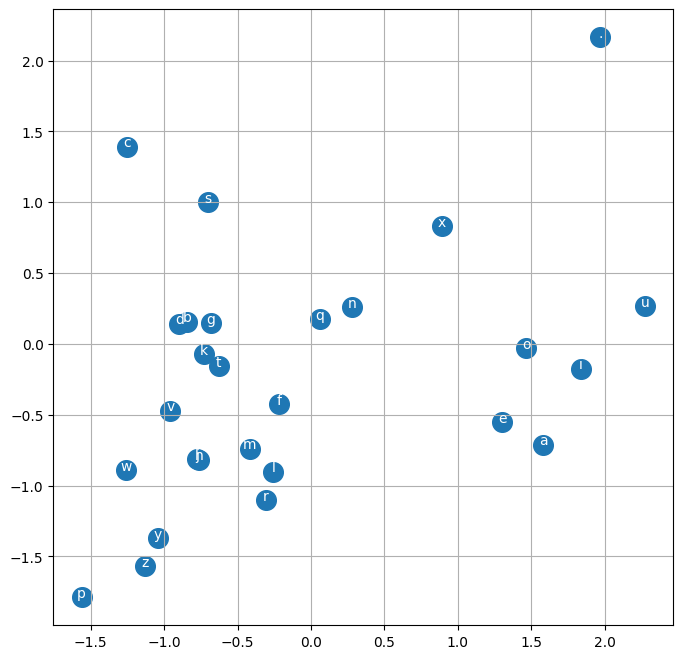

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",color="white")
  plt.grid('minor')

In [43]:
# Sample from the model
g=torch.Generator().manual_seed(19)

for _ in range(20):
  out=[]
  context=[0]* block_size
  while True:
    emb=C[torch.tensor([context])]
    embcat=emb.view(emb.shape[0],-1)
    hprebn=embcat @ W1 +b1
    bnmeani=1/n*hprebn.sum(0,keepdim=True)
    bndiff=hprebn-bnmeani
    bndiff2=bndiff**2
    bnvar=1/(n-1)*(bndiff2).sum(0,keepdim=True) #Bessel's correction i.e dividing by (n-1) not n
    bnvar_inv=(bnvar+1e-5)**-0.5
    bnraw=bndiff*bnvar_inv
    hpreact= bngain*bnraw+bnbias
    hpreact=bngain*(hpreact-bnmeani)+bnbias
    h=torch.tanh(hpreact)
    logits=h @ W2+b2
    probs=F.softmax(logits,dim=1)
    ix=torch.multinomial(probs, num_samples=1, generator=g).item()
    context=context[1:]+[ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))

samjinnrmeapprek.
sara.
pumaajzi.
sand.
kand.
maralanjez.
ilampuramalschangaambha.
lapshanpav.
sajjonhav.
pagapai.
kaf.
garans.
arljebches.
shaanhaqamp.
iushubama.
hal.
saaja.
kokpa.
paran.
map.


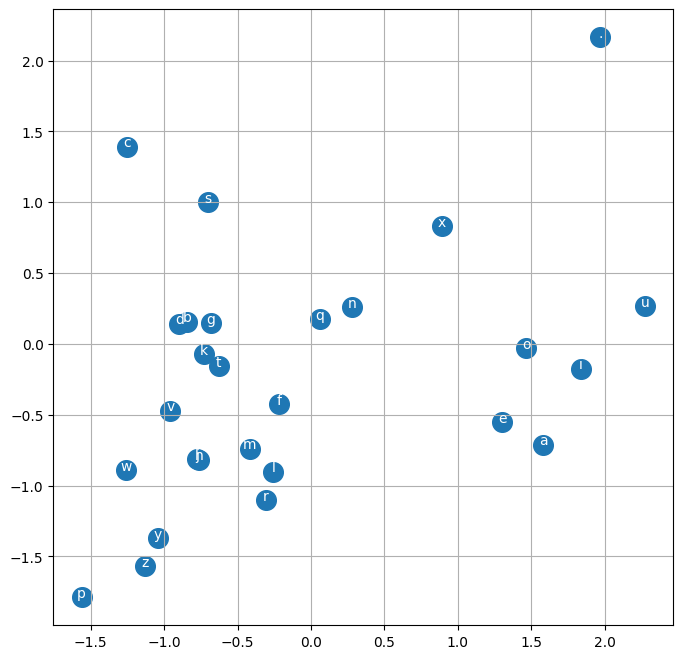

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",color="white")
  plt.grid('minor')